### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from difflib import get_close_matches
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import warnings

warnings.filterwarnings("ignore")


### Load and Preview Data

In [3]:
disease_data = pd.read_csv('disease.csv')
description_data = pd.read_csv('disease_description.csv')
precaution_data = pd.read_csv('disease_precaution.csv')

disease_data.head(), description_data.head(), precaution_data.head()


(            disease   Symptom_1              Symptom_2              Symptom_3  \
 0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
 1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
 2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   
 3  Fungal infection     itching              skin_rash    dischromic _patches   
 4  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
 
               Symptom_4 Symptom_5 Symptom_6 Symptom_7 Symptom_8 Symptom_9  \
 0   dischromic _patches       NaN       NaN       NaN       NaN       NaN   
 1                   NaN       NaN       NaN       NaN       NaN       NaN   
 2                   NaN       NaN       NaN       NaN       NaN       NaN   
 3                   NaN       NaN       NaN       NaN       NaN       NaN   
 4                   NaN       NaN       NaN       NaN       NaN       NaN   
 
   Symptom_10 Symptom_11 Symptom_12 

In [4]:
disease_data

,disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,(vertigo) Paroymsal Positional Vertigo,vomiting,headache,nausea,spinning_movements,loss_of_balance,unsteadiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4916,Acne,skin_rash,pus_filled_pimples,blackheads,scurring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4917,Urinary tract infection,burning_micturition,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4918,Psoriasis,skin_rash,joint_pain,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Transform

In [5]:
symptom_columns = disease_data.columns[1:]
disease_data_long = disease_data.melt(id_vars="disease", value_vars=symptom_columns, value_name="Symptom").dropna()

# Create a one-hot encoded DataFrame
symptom_dummies = pd.get_dummies(disease_data_long["Symptom"])
disease_data_transformed = pd.concat([disease_data_long["disease"], symptom_dummies], axis=1)

# Aggregate to get the final format
final_disease_data = disease_data_transformed.groupby("disease").max().reset_index()

# Display the transformed DataFrame
final_disease_data

,disease,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,...,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
0,(vertigo) Paroymsal Positional Vertigo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AIDS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Acne,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Alcoholic hepatitis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Allergy,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,Arthritis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Bronchial Asthma,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Cervical spondylosis,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
8,Chicken pox,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,Chronic cholestasis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


### Handle missing data

In [6]:
# Check for missing values and clean data
print(final_disease_data.info())
print(description_data.info())
print(precaution_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Columns: 132 entries, disease to itching
dtypes: object(1), uint8(131)
memory usage: 5.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   disease      41 non-null     object
 1   description  41 non-null     object
dtypes: object(2)
memory usage: 784.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   disease       41 non-null     object
 1   Precaution_1  41 non-null     object
 2   Precaution_2  41 non-null     object
 3   Precaution_3  40 non-null     object
 4   Precaution_4  40 non-null     object
dtypes: object(5)
memory usage: 1.7+ KB
None


In [7]:
description_data['description'].fillna('No description available', inplace=True)
for col in precaution_data.columns[1:]:  # Applies to Precaution_1, Precaution_2, etc.
    precaution_data[col].fillna('No precaution', inplace=True)

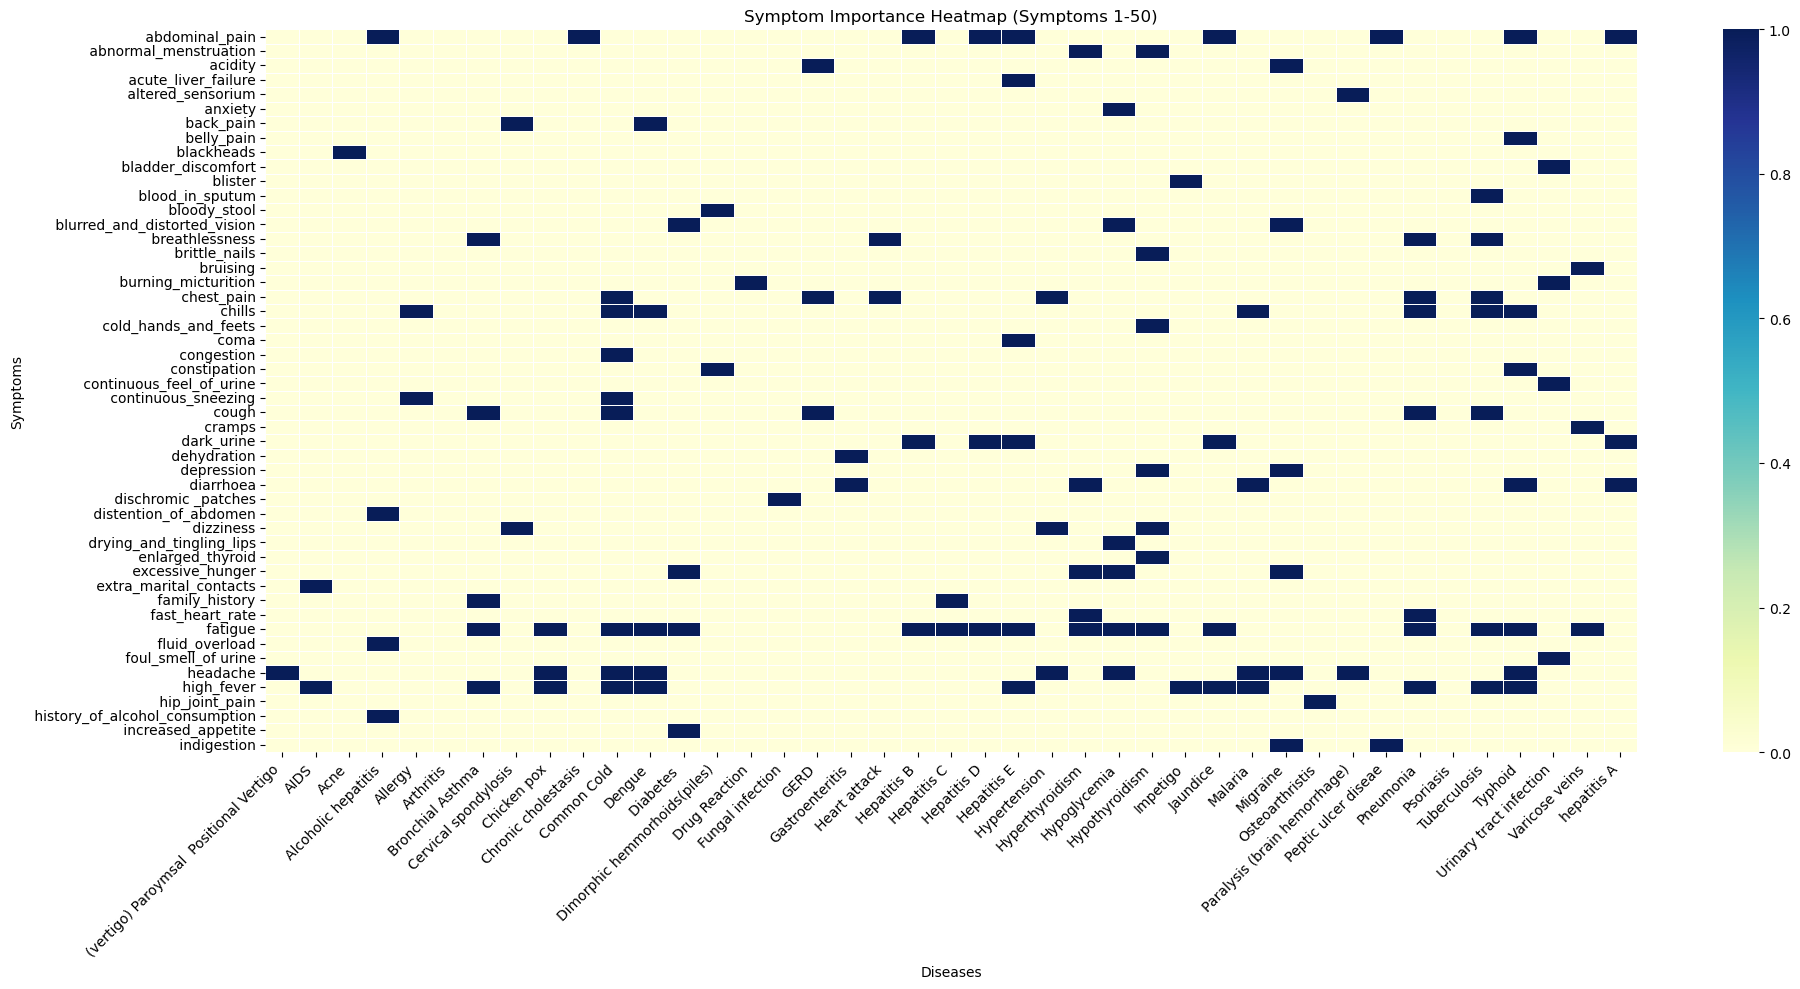

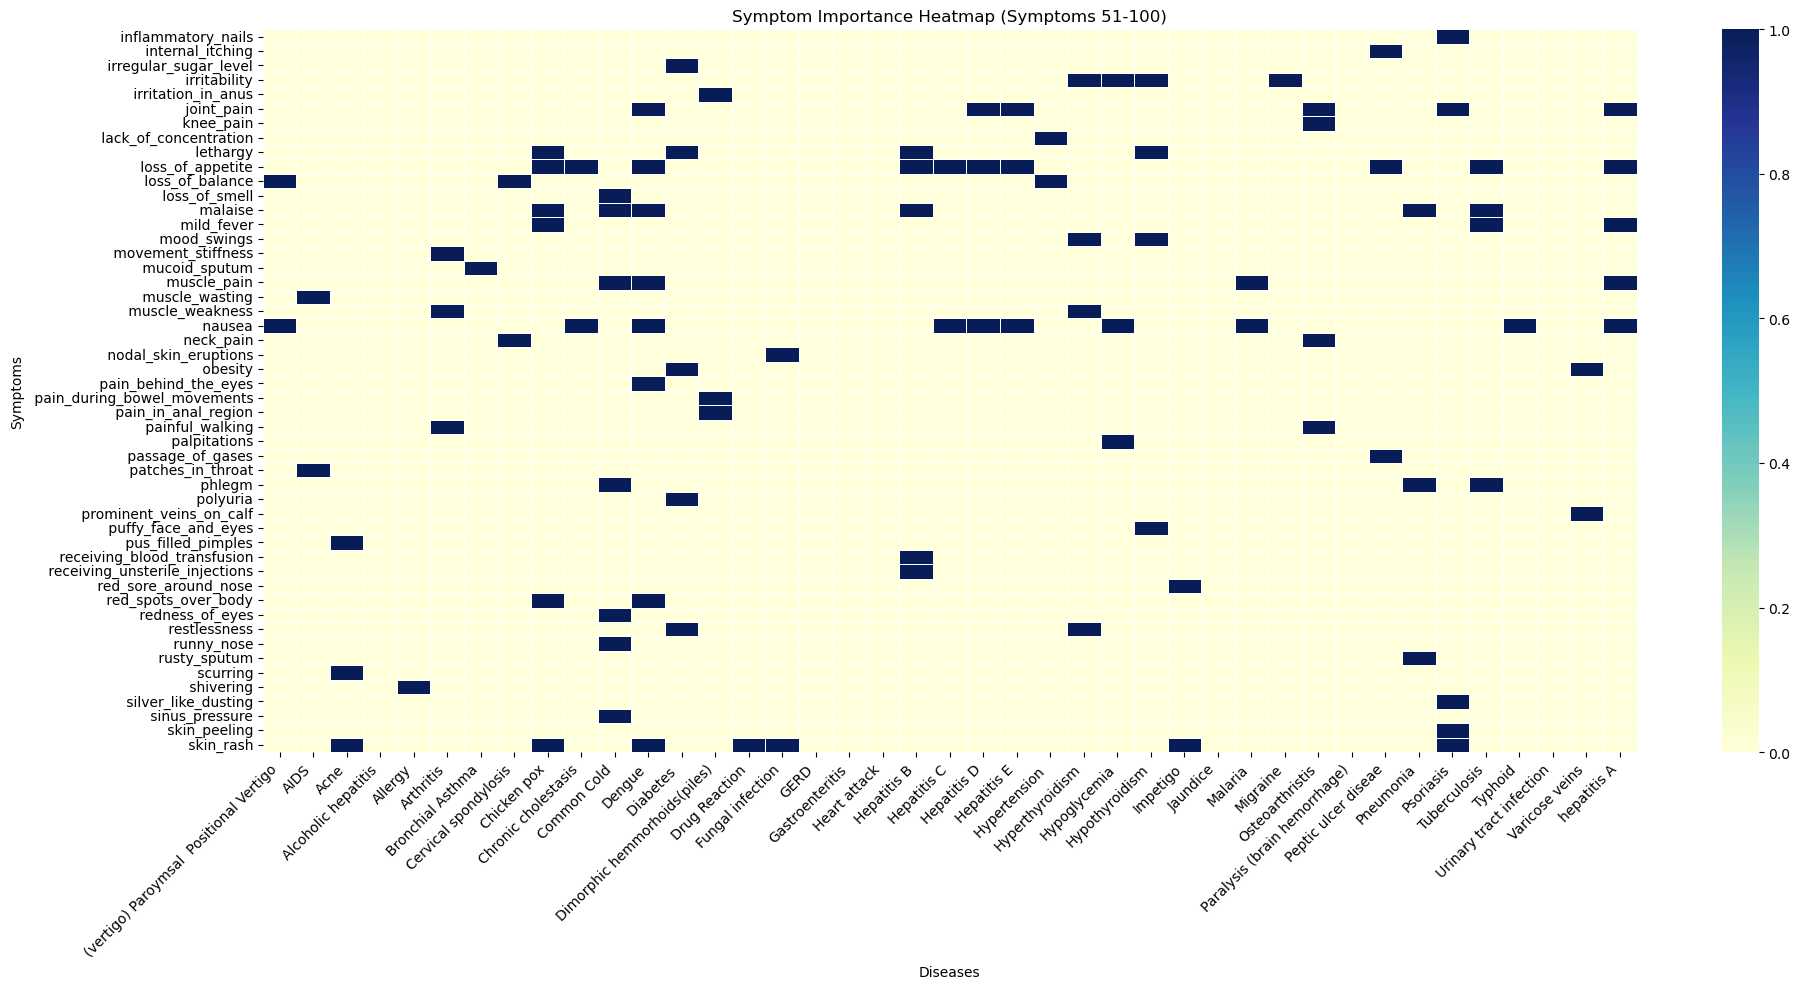

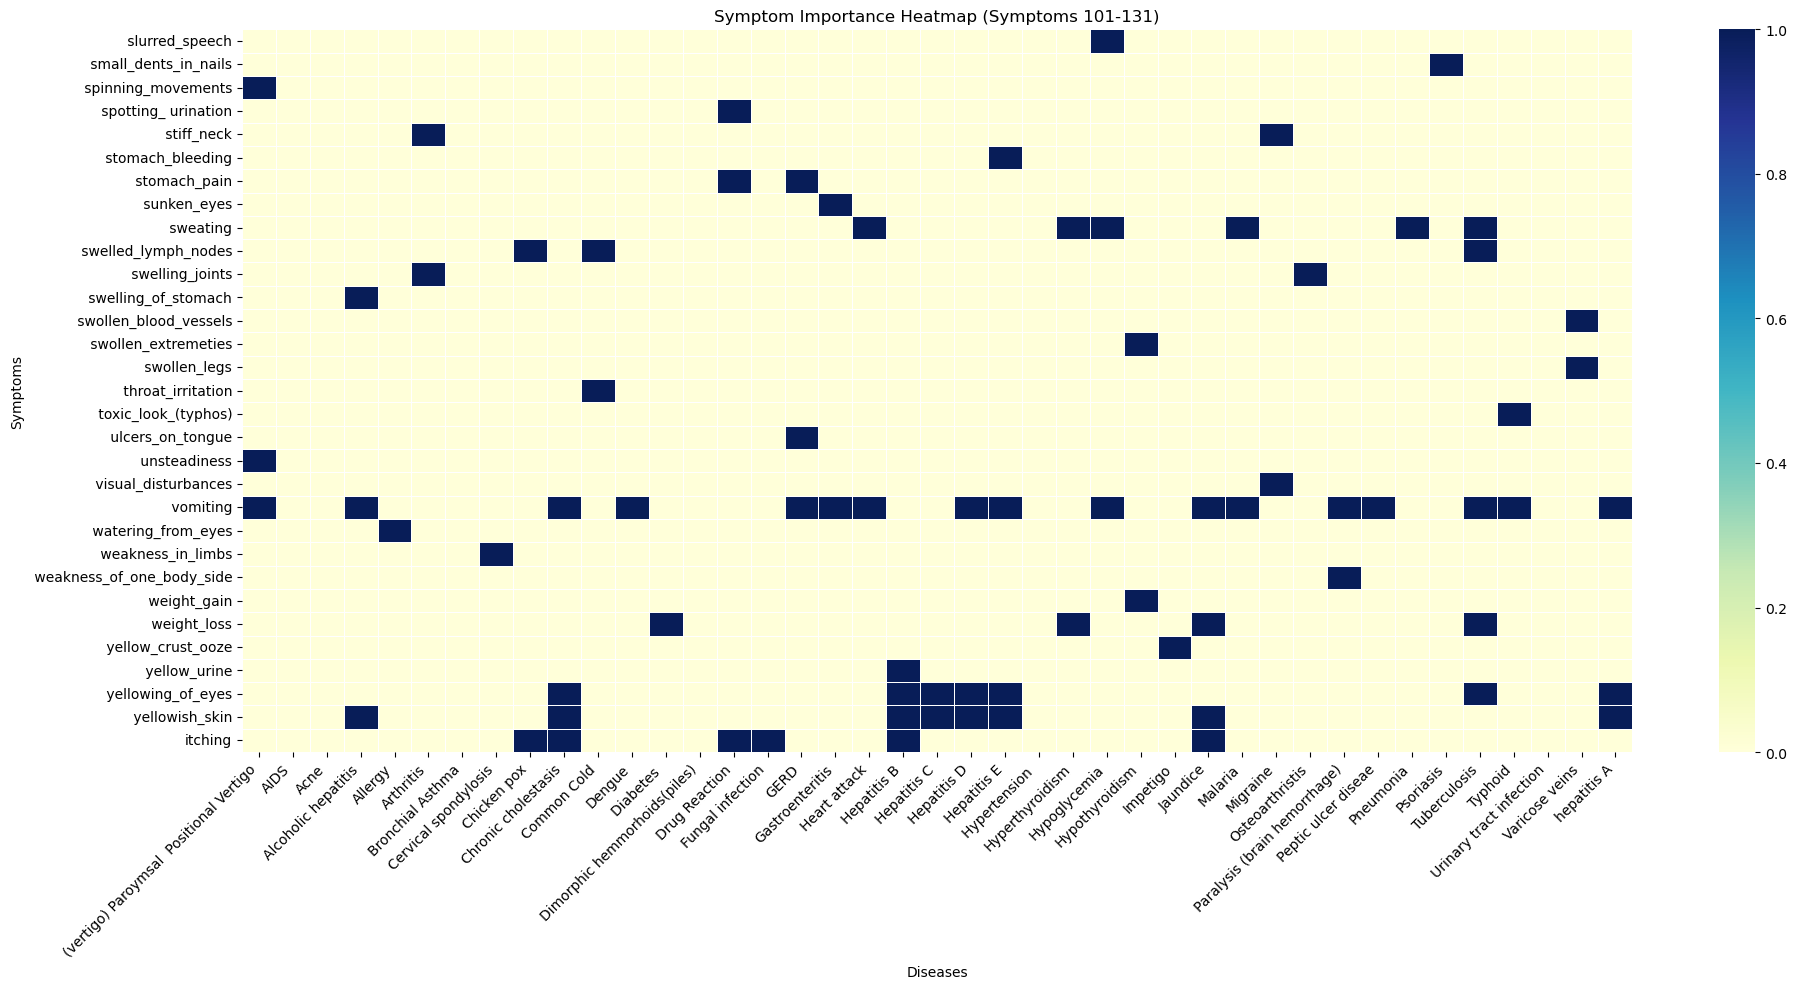

In [8]:
# Define heatmap_data from final_disease_data
heatmap_data = final_disease_data.set_index('disease')  # Set diseases as index

# Split symptoms into chunks of 50 for easier visualization
chunk_size = 50
symptoms = heatmap_data.T.index.tolist()  # Transpose to access symptoms as rows
for i in range(0, len(symptoms), chunk_size):
    chunk = heatmap_data.T.iloc[i:i+chunk_size, :]  # Select a chunk of symptoms
    plt.figure(figsize=(20, 10))
    sns.heatmap(
        chunk,
        cmap="YlGnBu",
        cbar=True,
        linewidths=0.5
    )
    plt.title(f"Symptom Importance Heatmap (Symptoms {i+1}-{min(i+chunk_size, len(symptoms))})")
    plt.xlabel("Diseases")
    plt.ylabel("Symptoms")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


### Data cleaning

In [9]:
def clean_text(text):
    # Remove special characters, underscores, and convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text.lower()
# Apply the cleaning function to all symptom columns in the disease_data
final_disease_data.columns = [clean_text(col.replace('_', ' ')) for col in final_disease_data.columns]
final_disease_data['disease'] = final_disease_data['disease'].astype(str).apply(clean_text)

# Clean the disease and description columns in description_data
description_data['disease'] = description_data['disease'].astype(str).apply(clean_text)
description_data['description'] = description_data['description'].astype(str).apply(clean_text)

# Clean the disease and precaution columns in precaution_data
precaution_data['disease'] = precaution_data['disease'].astype(str).apply(clean_text)
for col in precaution_data.columns[1:]:  # Apply to Precaution_1, Precaution_2, etc.
    precaution_data[col] = precaution_data[col].astype(str).apply(clean_text)

In [12]:
# Display the cleaned data to verify
print("\nCleaned Disease Data:")
print(final_disease_data.head())

print("\nCleaned Description Data:")
print(description_data.head())

print("\nCleaned Precaution Data:")
print(precaution_data.head())


Cleaned Disease Data:


,disease,abdominal pain,abnormal menstruation,acidity,acute liver failure,altered sensorium,anxiety,back pain,belly pain,blackheads,...,watering from eyes,weakness in limbs,weakness of one body side,weight gain,weight loss,yellow crust ooze,yellow urine,yellowing of eyes,yellowish skin,itching
0,vertigo paroymsal positional vertigo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,aids,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,acne,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,alcoholic hepatitis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,allergy,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,arthritis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,bronchial asthma,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,cervical spondylosis,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
8,chicken pox,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,chronic cholestasis,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [9]:
output_file = 'cleaned_disease_data.csv'
final_disease_data.to_csv(output_file, index=False)

print(f"Transformed data has been saved to {output_file}")

Transformed data has been saved to cleaned_disease_data.csv


In [10]:
data=pd.read_csv("cleaned_disease_data.csv")
data, data.shape

(                                 disease  abdominal pain  \
 0   vertigo paroymsal positional vertigo               0   
 1                                   aids               0   
 2                                   acne               0   
 3                    alcoholic hepatitis               1   
 4                                allergy               0   
 5                              arthritis               0   
 6                       bronchial asthma               0   
 7                   cervical spondylosis               0   
 8                            chicken pox               0   
 9                    chronic cholestasis               1   
 10                           common cold               0   
 11                                dengue               0   
 12                              diabetes               0   
 13            dimorphic hemmorhoidspiles               0   
 14                         drug reaction               0   
 15                     

### Merge data

In [11]:
merged_data = pd.merge(
    pd.merge(final_disease_data, description_data, on='disease', how='left'),
    precaution_data, 
    on='disease', 
    how='left'
)
merged_data


,disease,abdominal pain,abnormal menstruation,acidity,acute liver failure,altered sensorium,anxiety,back pain,belly pain,blackheads,...,yellow crust ooze,yellow urine,yellowing of eyes,yellowish skin,itching,description,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,vertigo paroymsal positional vertigo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,benign paroxysmal positional vertigo bppv is o...,lie down,avoid sudden change in body,avoid abrupt head movment,relax
1,aids,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,acquired immunodeficiency syndrome aids is a c...,avoid open cuts,wear ppe if possible,consult doctor,follow up
2,acne,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,acne vulgaris is the formation of comedones pa...,bath twice,avoid fatty spicy food,drink plenty of water,avoid too many products
3,alcoholic hepatitis,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,alcoholic hepatitis is a diseased inflammatory...,stop alcohol consumption,consult doctor,medication,follow up
4,allergy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,an allergy is an immune system response to a f...,apply calamine,cover area with bandage,no precaution,use ice to compress itching
5,arthritis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,arthritis is the swelling and tenderness of on...,exercise,use hot and cold therapy,try acupuncture,massage
6,bronchial asthma,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,bronchial asthma is a medical condition which ...,switch to loose cloothing,take deep breaths,get away from trigger,seek help
7,cervical spondylosis,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,cervical spondylosis is a general term for age...,use heating pad or cold pack,exercise,take otc pain reliver,consult doctor
8,chicken pox,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,chickenpox is a highly contagious disease caus...,use neem in bathing,consume neem leaves,take vaccine,avoid public places
9,chronic cholestasis,1,0,0,0,0,0,0,0,0,...,0,0,1,1,1,chronic cholestatic diseases whether occurring...,cold baths,anti itch medicine,consult doctor,eat healthy


### Prepare data for CNN

In [12]:
X_symptoms = merged_data.drop(columns=['disease', 'description', 'Precaution_1', 'Precaution_2', 'Precaution_3', 'Precaution_4'])
y_disease = merged_data['disease']

X_symptoms = X_symptoms.values
X_symptoms = np.expand_dims(X_symptoms, axis=-1)  

le = LabelEncoder()
y_encoded = le.fit_transform(y_disease)
y_categorical = to_categorical(y_encoded)  

print(f"X_symptoms shape: {X_symptoms.shape}")
print(f"y_categorical shape: {y_categorical.shape}")

X_symptoms shape: (41, 131, 1)
y_categorical shape: (41, 41)


### Define and Train CNN Model

In [13]:
# Define and Train CNN Model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_symptoms.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_symptoms, y_categorical, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step - accuracy: 0.0000e+00 - loss: 3.7088 - val_accuracy: 0.0000e+00 - val_loss: 3.7237
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2500 - loss: 3.6540 - val_accuracy: 0.0000e+00 - val_loss: 3.7302
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4688 - loss: 3.6031 - val_accuracy: 0.0000e+00 - val_loss: 3.7378
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5625 - loss: 3.5530 - val_accuracy: 0.0000e+00 - val_loss: 3.7461
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6562 - loss: 3.5020 - val_accuracy: 0.0000e+00 - val_loss: 3.7548
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6562 - loss: 3.4487 - val_accuracy: 0.0000e+00 - val_loss: 3.7672
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7188 - loss: 3.3921 - val_accuracy: 0.0000e+00 - val_loss: 3.7824
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7188 - loss: 3.3320 - val_acc

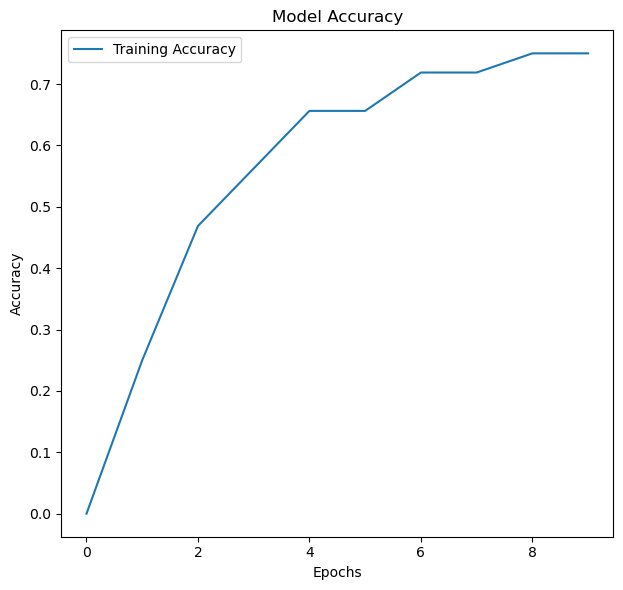

In [14]:
# Plot training performance
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# # Loss plot
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

plt.tight_layout()
plt.show()


### Fuzzy Logic Setup

In [15]:
# Fuzzy Logic Setup
def setup_fuzzy_logic():
    intensity = ctrl.Antecedent(np.arange(0, 11, 1), 'intensity')
    probability = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'probability')

    intensity['low'] = fuzz.trimf(intensity.universe, [0, 0, 5])
    intensity['medium'] = fuzz.trimf(intensity.universe, [3, 5, 7])
    intensity['high'] = fuzz.trimf(intensity.universe, [5, 10, 10])

    probability['low'] = fuzz.trimf(probability.universe, [0, 0, 0.5])
    probability['medium'] = fuzz.trimf(probability.universe, [0.3, 0.5, 0.7])
    probability['high'] = fuzz.trimf(probability.universe, [0.5, 1, 1])

    rule1 = ctrl.Rule(intensity['low'], probability['low'])
    rule2 = ctrl.Rule(intensity['medium'], probability['medium'])
    rule3 = ctrl.Rule(intensity['high'], probability['high'])

    probability_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
    return ctrl.ControlSystemSimulation(probability_ctrl)


<Figure size 1000x500 with 0 Axes>

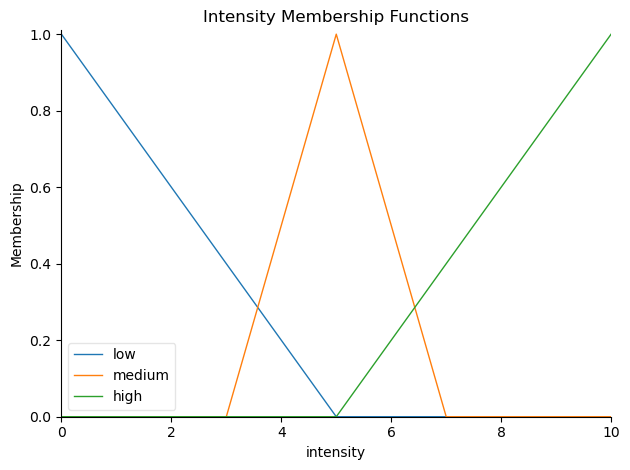

In [16]:
# Visualize membership functions
intensity = ctrl.Antecedent(np.arange(0, 11, 1), 'intensity')
intensity['low'] = fuzz.trimf(intensity.universe, [0, 0, 5])
intensity['medium'] = fuzz.trimf(intensity.universe, [3, 5, 7])
intensity['high'] = fuzz.trimf(intensity.universe, [5, 10, 10])

plt.figure(figsize=(10, 5))
intensity.view()
plt.title("Intensity Membership Functions")
plt.tight_layout()
plt.show()


### Calculate Disease Probabilities

In [17]:
# Calculate disease probabilities
def calculate_disease_probabilities(input_symptoms, model, symptom_columns, label_encoder, merged_data):
    input_vector = np.zeros(len(symptom_columns), dtype=int)
    for symptom in input_symptoms:
        if symptom in symptom_columns:
            input_vector[symptom_columns.index(symptom)] = 1

    input_vector = input_vector.reshape(1, -1, 1)
    predictions = model.predict(input_vector)
    predicted_label = np.argmax(predictions)
    predicted_disease = label_encoder.inverse_transform([predicted_label])[0]
    
    match_probabilities = {}
    total_input_symptoms = len(input_symptoms)
    for disease in merged_data['disease']:
        disease_row = merged_data[merged_data['disease'] == disease].iloc[0]
        disease_symptoms = disease_row.drop(labels=['disease', 'description', 'Precaution_1', 'Precaution_2', 'Precaution_3', 'Precaution_4']).values
        matched_symptoms = sum([1 for symptom in input_symptoms if symptom in symptom_columns and disease_symptoms[symptom_columns.index(symptom)] == 1])
        match_probability = matched_symptoms / total_input_symptoms if total_input_symptoms > 0 else 0
        if match_probability > 0:
            match_probabilities[disease] = match_probability
            
            
    sorted_probabilities = sorted(match_probabilities.items(), key=lambda x: x[1], reverse=True)
    return predicted_disease, sorted_probabilities

### Refine Probabilities with Fuzzy Logic

In [18]:
def refine_with_fuzzy(cnn_probabilities, symptom_intensities):
    probability_sim = setup_fuzzy_logic()

    refined_probabilities = []
    for disease, cnn_prob in cnn_probabilities:
        average_intensity = np.mean(symptom_intensities)
        probability_sim.input['intensity'] = average_intensity
        probability_sim.compute()
        adjusted_prob = cnn_prob * probability_sim.output['probability']
        refined_probabilities.append((disease, adjusted_prob))

    total = sum(prob for _, prob in refined_probabilities)
    if total > 0:
        refined_probabilities = [(disease, prob / total) for disease, prob in refined_probabilities]

    refined_probabilities.sort(key=lambda x: x[1], reverse=True)
    return refined_probabilities


### Get User Input with Suggestions

In [19]:
# Helper function to suggest the closest symptom if the input is not recognized
def get_closest_symptom(input_symptom, symptom_columns):
    from difflib import get_close_matches
    matches = get_close_matches(input_symptom, symptom_columns, n=1, cutoff=0.7)
    return matches[0] if matches else None

# Function to gather user input for symptoms and their intensities
def get_user_input_with_suggestions(symptom_columns):
    print("\nAvailable Symptoms (in alphabetical order):")
    sorted_symptoms = sorted(symptom_columns)
    for symptom in sorted_symptoms:
        print(symptom, end=", ")
    print("\n\nEnter symptoms (comma-separated). Type 'done' when finished.")

    input_symptoms = []
    symptom_intensities = []

    while True:
        symptoms = input("\nEnter symptoms: ").strip().lower().split(',')
        if symptoms[0] == 'done':
            break
        for symptom in symptoms:
            symptom = symptom.strip()
            if symptom in symptom_columns:
                try:
                    intensity = float(input(f"Enter intensity for '{symptom}' (0-10): ").strip())
                    if 0 <= intensity <= 10:
                        input_symptoms.append(symptom)
                        symptom_intensities.append(intensity / 10.0)  # Normalize intensity to 0-1
                    else:
                        print("Intensity must be between 0 and 10. Please try again.")
                except ValueError:
                    print("Invalid intensity. Please enter a numeric value.")
            else:
                closest = get_closest_symptom(symptom, symptom_columns)
                if closest:
                    print(f"Did you mean '{closest}'?")
                    confirm = input("Enter 'yes' to confirm or 'no' to re-enter: ").strip().lower()
                    if confirm == 'yes':
                        try:
                            intensity = float(input(f"Enter intensity for '{closest}' (0-10): ").strip())
                            if 0 <= intensity <= 10:
                                input_symptoms.append(closest)
                                symptom_intensities.append(intensity / 10.0)  # Normalize intensity to 0-1
                            else:
                                print("Intensity must be between 0 and 10. Please try again.")
                        except ValueError:
                            print("Invalid intensity. Please enter a numeric value.")
                else:
                    print(f"Symptom '{symptom}' not recognized. Please try again.")

    return input_symptoms, symptom_intensities


### Predict and Refine Disease Probabilities

In [20]:
symptom_columns = list(merged_data.drop(columns=['disease', 'description', 'Precaution_1', 'Precaution_2', 'Precaution_3', 'Precaution_4']).columns)
input_symptoms, symptom_intensities = get_user_input_with_suggestions(symptom_columns)

if not input_symptoms:
    print("\nNo symptoms were entered. Please try again.")
else:
    predicted_disease, cnn_probabilities = calculate_disease_probabilities(
        input_symptoms, 
        model, 
        symptom_columns, 
        le, 
        merged_data
    )
    refined_probabilities = refine_with_fuzzy(cnn_probabilities, symptom_intensities)

    print("\nRefined Disease Probabilities:")
    i=1
    for disease, prob in refined_probabilities:
        print(f"{i}. {disease}: {prob:.2f}")
        i += 1



Available Symptoms (in alphabetical order):
abdominal pain, abnormal menstruation, acidity, acute liver failure, altered sensorium, anxiety, back pain, belly pain, blackheads, bladder discomfort, blister, blood in sputum, bloody stool, blurred and distorted vision, breathlessness, brittle nails, bruising, burning micturition, chest pain, chills, cold hands and feets, coma, congestion, constipation, continuous feel of urine, continuous sneezing, cough, cramps, dark urine, dehydration, depression, diarrhoea, dischromic patches, distention of abdomen, dizziness, drying and tingling lips, enlarged thyroid, excessive hunger, extra marital contacts, family history, fast heart rate, fatigue, fluid overload, foul smell of urine, headache, high fever, hip joint pain, history of alcohol consumption, increased appetite, indigestion, inflammatory nails, internal itching, irregular sugar level, irritability, irritation in anus, itching, joint pain, knee pain, lack of concentration, lethargy, loss 

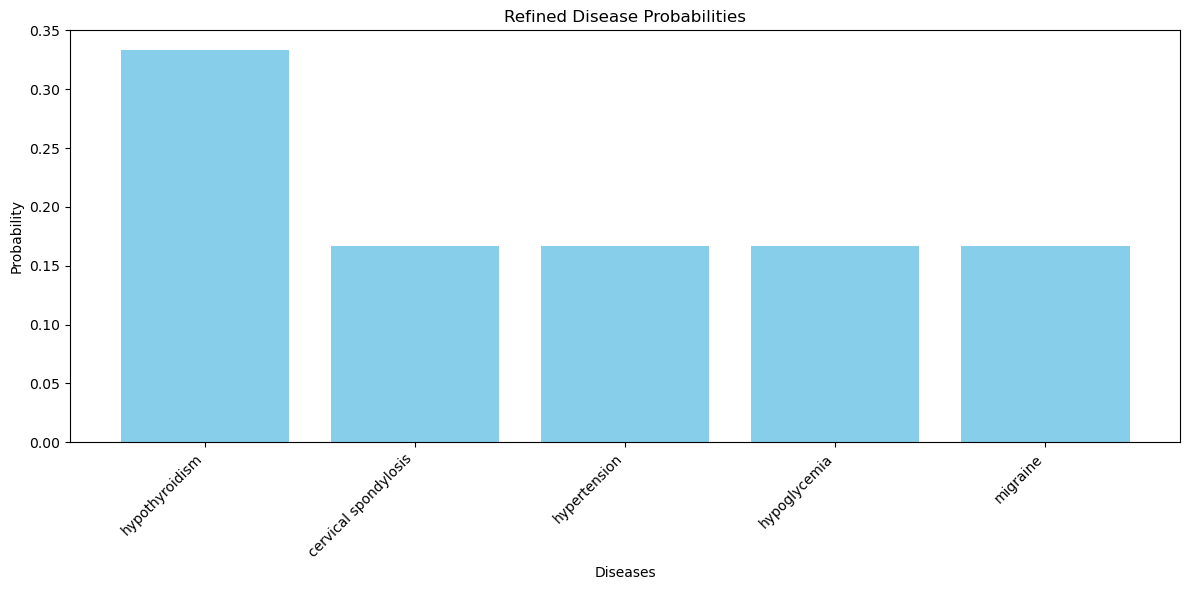

In [21]:
# Visualize refined probabilities
diseases, probabilities = zip(*refined_probabilities)

plt.figure(figsize=(12, 6))
plt.bar(diseases, probabilities, color='skyblue')
plt.title("Refined Disease Probabilities")
plt.xlabel("Diseases")
plt.ylabel("Probability")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Display Disease Details and Precautions

In [22]:
# Get Disease Details
def get_disease_details(selected_diseases, merged_data):
    disease_details = []
    for disease in selected_diseases:
        disease_row = merged_data[merged_data['disease'] == disease].iloc[0]
        description = disease_row['description']
        precautions = [disease_row.get(f'Precaution_{i}', 'N/A') for i in range(1, 5)]
        disease_details.append({
            'disease': disease,
            'description': description,
            'precautions': precautions
        })
    return disease_details


# Let user choose how many diseases to display
m = int(input("\nEnter the number of top diseases to view details for: "))
top_diseases = [disease for disease, prob in refined_probabilities[:m]]
disease_details = get_disease_details(top_diseases, merged_data)
print("\nSelected Disease Details:")
for details in disease_details:
    print(f"\nDisease: {details['disease']}")
    print(f"Description: {details['description']}")
    print("Precautions:")
    for precaution in details['precautions']:
        print(f"- {precaution}")


Enter the number of top diseases to view details for: 3

Selected Disease Details:

Disease: hypothyroidism
Description: hypothyroidism also called underactive thyroid or low thyroid is a disorder of the endocrine system in which the thyroid gland does not produce enough thyroid hormone
Precautions:
- reduce stress
- exercise
- eat healthy
- get proper sleep

Disease: cervical spondylosis
Description: cervical spondylosis is a general term for agerelated wear and tear affecting the spinal disks in your neck as the disks dehydrate and shrink signs of osteoarthritis develop including bony projections along the edges of bones bone spurs
Precautions:
- use heating pad or cold pack
- exercise
- take otc pain reliver
- consult doctor

Disease: hypertension
Description: hypertension htn or ht also known as high blood pressure hbp is a longterm medical condition in which the blood pressure in the arteries is persistently elevated high blood pressure typically does not cause symptoms
Precautio